Context

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.
Content


Attribute Information:
age - age in years
sex - (1 = male; 0 = female)
cp - chest pain type
trestbps - resting blood pressure (in mm Hg on admission to the hospital)
chol - serum cholestoral in mg/dl
fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
restecg - resting electrocardiographic results
thalach - maximum heart rate achieved
exang - exercise induced angina (1 = yes; 0 = no)
oldpeak - ST depression induced by exercise relative to rest
slope - the slope of the peak exercise ST segment
ca - number of major vessels (0-3) colored by flourosopy
thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
target - have disease or not (1=yes, 0=no

IMPORTING LIBRARIES

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility
import plotly.graph_objs as go
import plotly.offline as py
py.offline.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None  #hide any pandas warnings
import numpy as np
import warnings
warnings.filterwarnings('ignore')
py.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline
# Plot in SVG format since this format is more sharp and legible
%config InlineBackend.figure_format = 'svg'
import xgboost as xgb 
from xgboost import XGBClassifier

LOADING DATA SET

In [101]:
dt=pd.read_csv("heart.csv", sep=",")

In [102]:
dt.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [103]:
#CHANGING THE DATA COLS NAMES TO MAKE MORE UNDERSTANDABLE THEM

In [104]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']
#60-70 chol ort

In [105]:
dt.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


ADDING NEW PROPERTIES(IMPORTANT COLUMNS)

In [106]:
df = dt.copy()

dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

In [107]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [108]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [109]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

DEFINE TARGET

In [110]:
dt.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [111]:
countNoDisease = len(dt[dt.target == 0])
countHaveDisease = len(dt[dt.target == 1])
print("Percentage of Patients Haven't Heart Disease: {:.2f}%".format((countNoDisease / (len(dt.target))*100)))
print("Percentage of Patients Have Heart Disease: {:.2f}%".format((countHaveDisease / (len(dt.target))*100)))

Percentage of Patients Haven't Heart Disease: 45.54%
Percentage of Patients Have Heart Disease: 54.46%


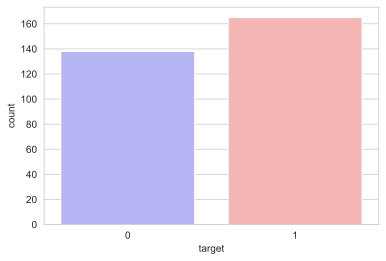

In [112]:
sns.countplot(x="target", data=dt, palette="bwr")
plt.show()

In [113]:
# Create table for missing data analysis-2
def find_missing_data(data):
    Total = dt.isnull().sum().sort_values(ascending = False)
    Percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    
    return pd.concat([Total,Percentage] , axis = 1 , keys = ['Total' , 'Percent'])

print("Missing values in the train data as Total and Percentage : \n")
display(find_missing_data(dt))

Missing values in the train data as Total and Percentage : 



,Total,Percent
target,0,0.0
thalassemia,0,0.0
num_major_vessels,0,0.0
st_slope,0,0.0
st_depression,0,0.0
exercise_induced_angina,0,0.0
max_heart_rate_achieved,0,0.0
rest_ecg,0,0.0
fasting_blood_sugar,0,0.0
cholesterol,0,0.0


In [114]:
dt.groupby('target').mean()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels
target,,,,,,
0,56.601449,134.398551,251.086957,139.101449,1.585507,1.166667
1,52.496970,129.303030,242.230303,158.466667,0.583030,0.363636


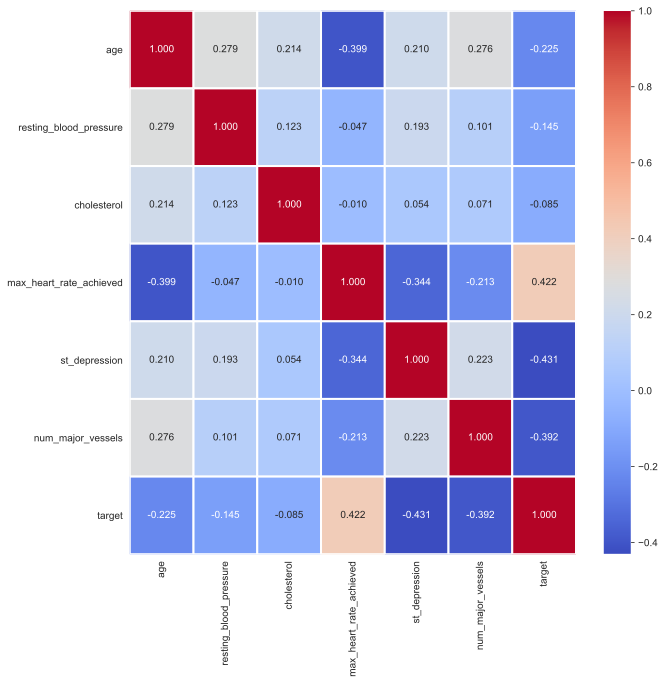

In [115]:
plt.figure(figsize=(10,10))
sns.heatmap(dt.corr(),annot=True,cmap='coolwarm',fmt='.3f',linewidths=2)
plt.show()

DATA VISUALIZATION

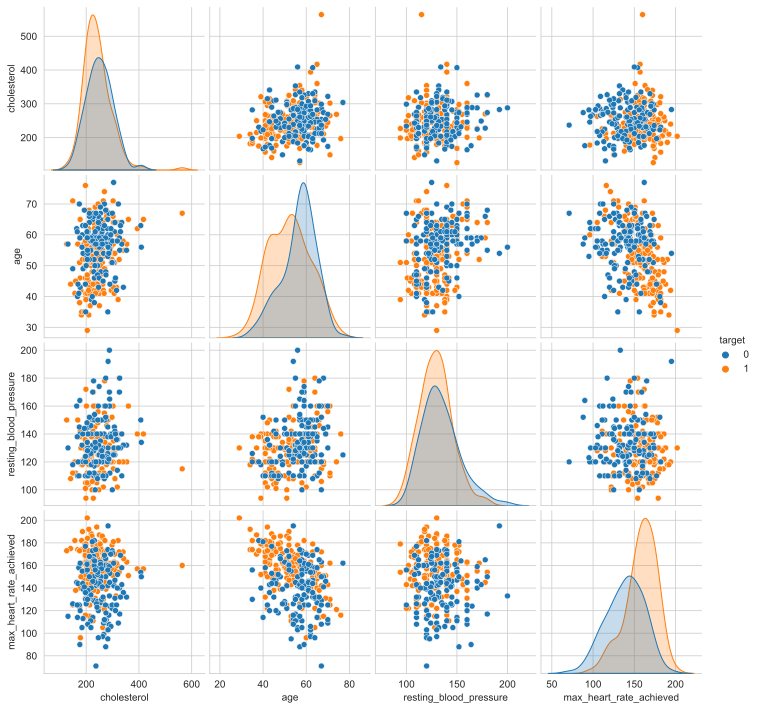

In [116]:
sns.pairplot(dt[['cholesterol', 'age', 'resting_blood_pressure', 'max_heart_rate_achieved', 'target']], hue='target');

Text(0.5, 1.0, 'Relation of tresbps with target')

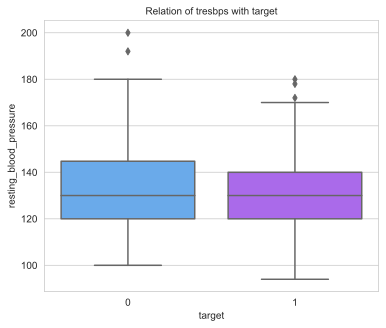

In [117]:
#This plot shows relationship between resting blood pressure and target
plt.figure(figsize=(6,5))
sns.boxplot(dt['target'], dt['resting_blood_pressure'], palette = 'cool')
plt.title('Relation of tresbps with target', fontsize = 10)



EXAMINING SEX AND TARGET RELATIONSHIPS

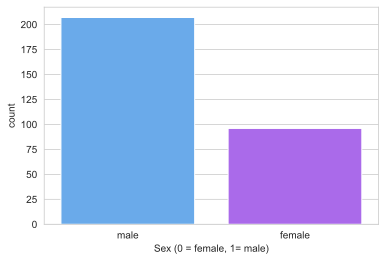

In [118]:
sns.countplot(x='sex', data=dt, palette="cool")
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()

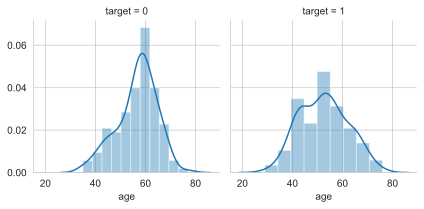

In [119]:
# Explore the Age vs  Heart Disease features
age_survived = sns.FacetGrid(dt, col='target')
age_survived = age_survived.map(sns.distplot, "age")


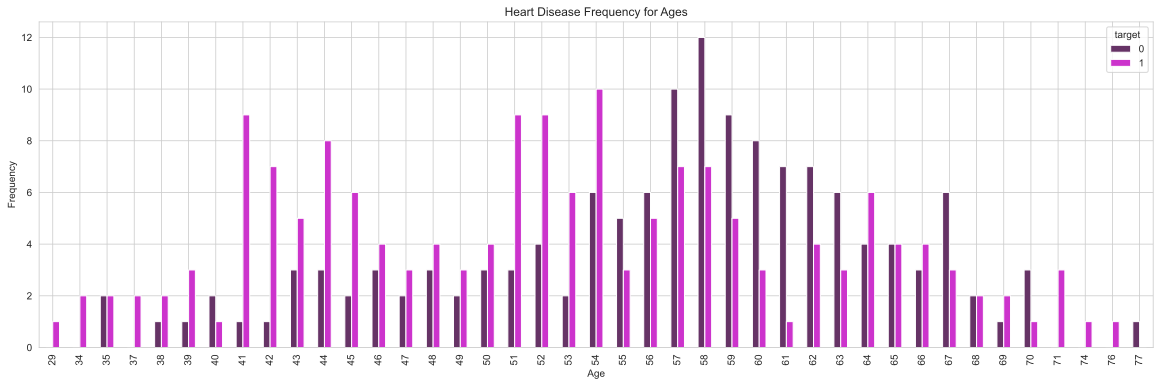

In [120]:
#EXAMINING RELATIONSHIPS BETWEEN HEART DISEASES FREQUENCIES RATES AND AGES
pd.crosstab(dt.age,dt.target).plot(kind="bar",figsize=(20,6),color=['#663366','#CC33CC' ])
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('heartDiseaseAndAges.png')
plt.show()



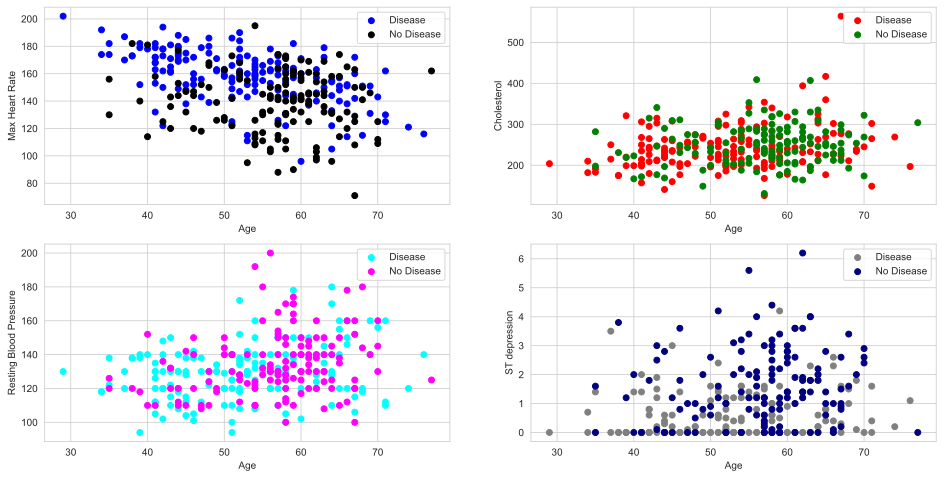

In [121]:

#Effect of parameters on Heart Disease based on Age

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.scatter(x=dt.age[dt.target==1],y=dt.max_heart_rate_achieved[dt.target==1],c='blue')
plt.scatter(x=dt.age[dt.target==0],y=dt.max_heart_rate_achieved[dt.target==0],c='black')
plt.xlabel('Age')
plt.ylabel('Max Heart Rate')
plt.legend(['Disease','No Disease'])

plt.subplot(2,2,2)
plt.scatter(x=dt.age[dt.target==1],y=dt.cholesterol[dt.target==1],c='red')
plt.scatter(x=dt.age[dt.target==0],y=dt.cholesterol[dt.target==0],c='green')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.legend(['Disease','No Disease'])

plt.subplot(2,2,3)
plt.scatter(x=dt.age[dt.target==1],y=dt.resting_blood_pressure[dt.target==1],c='cyan')
plt.scatter(x=dt.age[dt.target==0],y=dt.resting_blood_pressure[dt.target==0],c='fuchsia')
plt.xlabel('Age')
plt.ylabel('Resting Blood Pressure')
plt.legend(['Disease','No Disease'])

plt.subplot(2,2,4)
plt.scatter(x=dt.age[dt.target==1],y=dt.st_depression[dt.target==1],c='grey')
plt.scatter(x=dt.age[dt.target==0],y=dt.st_depression[dt.target==0],c='navy')
plt.xlabel('Age')
plt.ylabel('ST depression')
plt.legend(['Disease','No Disease'])
plt.show()



In [122]:
#EXAMINING RELATIONSHIPS BETWEEN HEART DISEASES FREQUENCIES RATES AND SEX


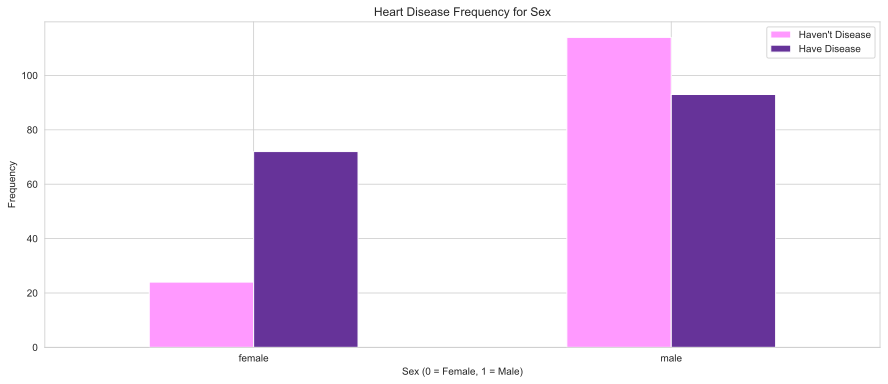

In [123]:
pd.crosstab(dt.sex,dt.target).plot(kind="bar",figsize=(15,6),color=['#FF99FF','#663399'])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()



In [124]:
# EXAMINING RELATIONSHIPS BETWEEN HEART DISEASES FREQUENCIES RATES AND SEX & AGE

<AxesSubplot:xlabel='age', ylabel='sex'>

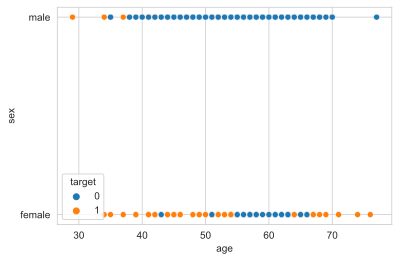

In [125]:
sns.scatterplot(x='age', y='sex', hue='target', data = dt)

EXAMINING RELATIONSHIPS BETWEEN MAX HEART RATE ACHIEVED AND RESTING AGE

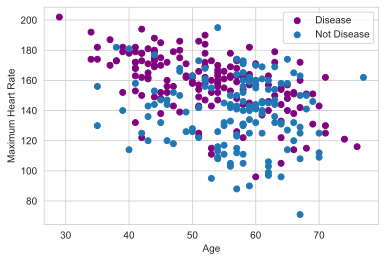

In [126]:
plt.scatter(x=dt.age[dt.target==1], y=dt.max_heart_rate_achieved[(dt.target==1)], c="purple")
plt.scatter(x=dt.age[dt.target==0], y=dt.max_heart_rate_achieved[(dt.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()



EXAMINING RELATIONSHIPS BETWEEN MAX HEART RATE ACHIEVED AND RESTING BLOOD PRESSURE

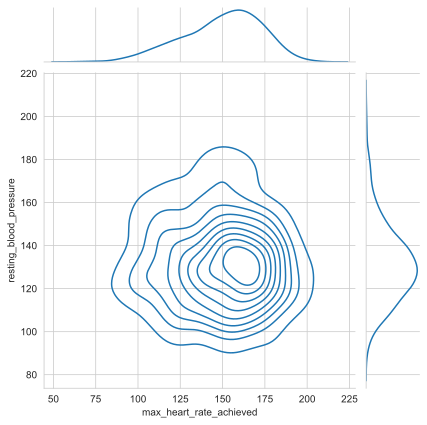

In [127]:
sns.jointplot(kind='kde', x='max_heart_rate_achieved', y='resting_blood_pressure', data=dt)
#This plot uses a color scale to represent the density, i.e. the local where the majority of the data points fall. 
#In this case, the points are concentrated around 170, 130 in the axis x and y respectively.


In [128]:
# First let's create a list to append the data to be plotted
data = []
for target in dt.target.unique():
    data.append(go.Box(y=dt[dt.target == target].max_heart_rate_achieved, name=str(target)))

layout = go.Layout(yaxis=dict(title ='maximum heart rate achieved', zeroline=False))
                   
fig = go.Figure(data=data, layout=layout)               
py.iplot(fig, show_link=False)


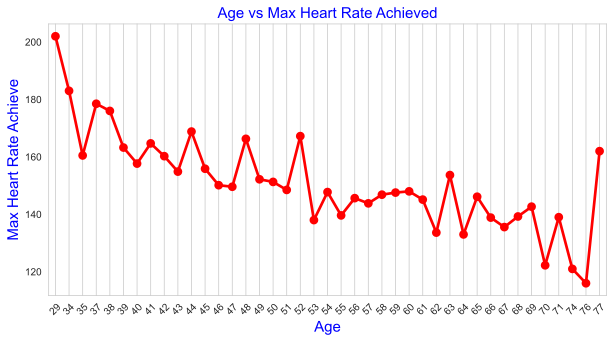

In [129]:
age_unique=sorted(dt.age.unique())
age_thalach_values=dt.groupby('age')['max_heart_rate_achieved'].count().values
mean_thalach=[]
for i,age in enumerate(age_unique):
    mean_thalach.append(sum(dt[dt['age']==age].max_heart_rate_achieved)/age_thalach_values[i])
    
plt.figure(figsize=(10,5))
sns.pointplot(x=age_unique,y=mean_thalach,color='red',alpha=0.8)
plt.xlabel('Age',fontsize = 15,color='blue')
plt.xticks(rotation=45)
plt.ylabel('Max Heart Rate Achieve',fontsize = 15,color='blue')
plt.title('Age vs Max Heart Rate Achieved',fontsize = 15,color='blue')
plt.grid()
plt.show()

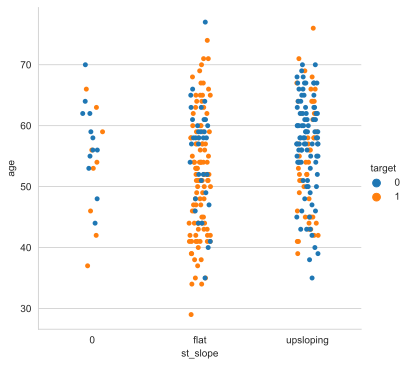

In [130]:
sns.catplot(x="st_slope", y="age", data = dt, hue = "target", c="purple");

<AxesSubplot:xlabel='st_slope', ylabel='count'>

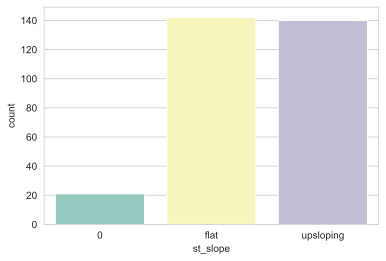

In [131]:
sns.countplot(x='st_slope',data=dt,palette='Set3')

<AxesSubplot:title={'center':'no_diseases'}, ylabel='target'>

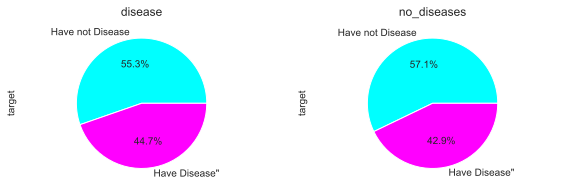

In [132]:
disease=dt[dt['st_slope']!=0]
no_diseases=dt[dt['st_slope']==0]
plt.figure(figsize=(20,3))
plt.subplot(141)
plt.axis('equal')
plt.title('disease')
disease['target'].value_counts().plot.pie(labels=['Have not Disease','Have Disease"'],autopct='%1.1f%%',colormap='cool')
plt.subplot(142)
plt.axis('equal')
plt.title('no_diseases')
no_diseases['target'].value_counts().plot.pie(labels=['Have not Disease','Have Disease"'],
        autopct='%1.1f%%',colormap='cool')

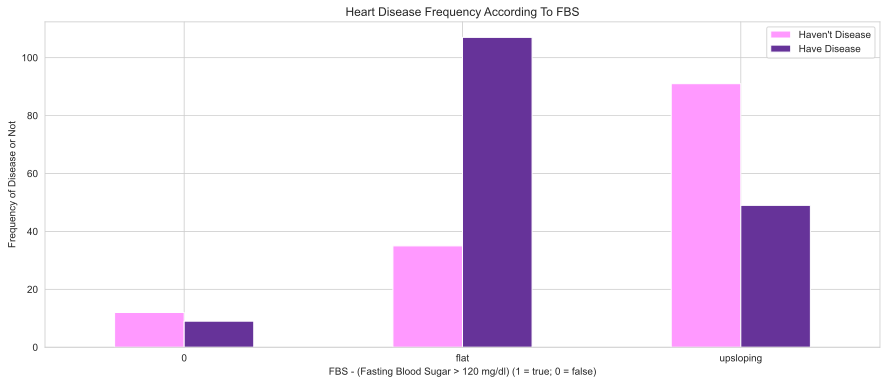

In [133]:
pd.crosstab(dt.st_slope,dt.target).plot(kind="bar",figsize=(15,6),color=['#FF99FF','#663399' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

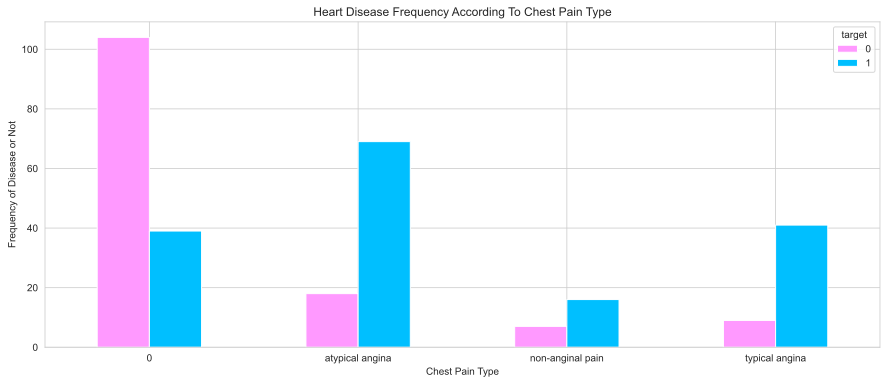

In [134]:
pd.crosstab(dt.chest_pain_type,dt.target).plot(kind="bar",figsize=(15,6),color=['#FF99FF','#00bfff'])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

In [135]:
#COHOLESTROL

<AxesSubplot:xlabel='age', ylabel='cholesterol'>

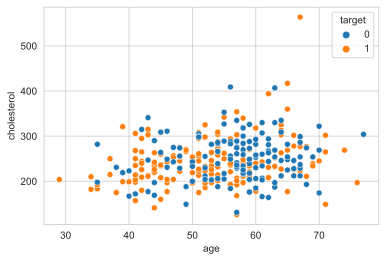

In [136]:
sns.scatterplot(x='age', y='cholesterol', hue='target', data = dt)

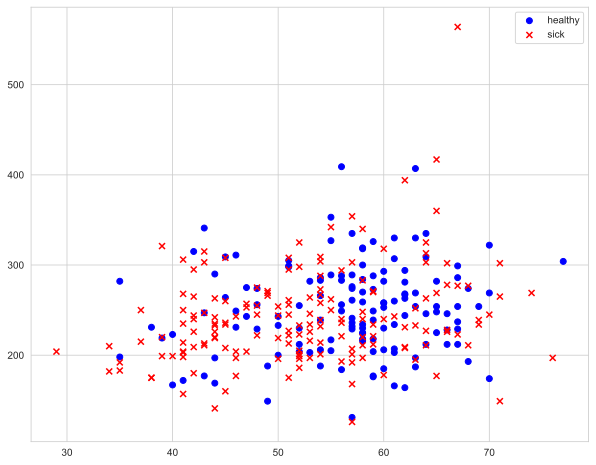

In [137]:
plt.figure(figsize=(10,8))
plt.scatter(dt[dt['target'] == 0]['age'], dt[dt['target'] == 0]['cholesterol'], marker='o', c='blue', label='healthy')
plt.scatter(dt[dt['target'] == 1]['age'], dt[dt['target'] == 1]['cholesterol'], marker='x', c='red', label='sick')

plt.legend()

Text(0.5, 1.0, ' Cholesterol vs Blood pressure in rest')

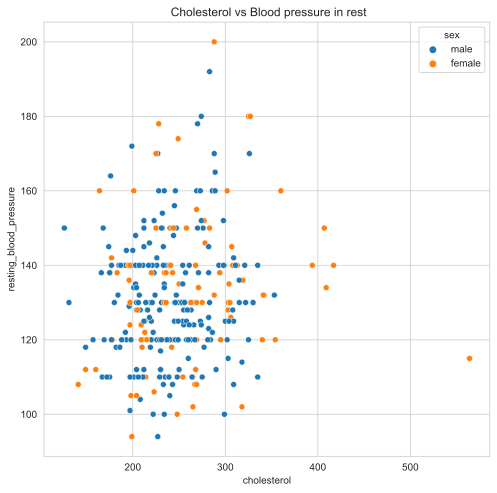

In [138]:
plt.rcParams['figure.figsize'] = (8,8)
sns.scatterplot(x='cholesterol', y='resting_blood_pressure', hue='sex', size=None, data=dt)
plt.title(' Cholesterol vs Blood pressure in rest')

CHEST PAIN TYPE & TARGET

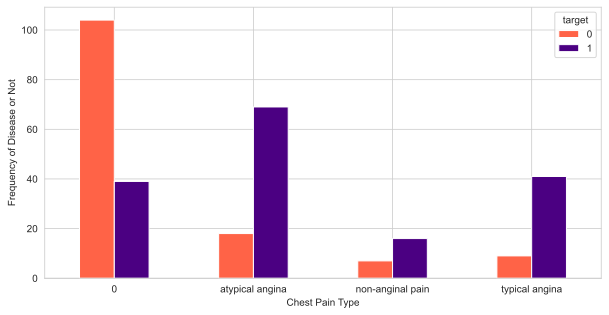

In [139]:
pd.crosstab(dt.chest_pain_type,dt.target).plot(kind="bar",figsize=(10,5),color=['tomato','indigo' ])
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

CHEST PAIN TYPE & CHOLESTROL

In [140]:
# First let's create a list to append the data to be plotted
data = []
for pain in dt.chest_pain_type.unique():
    data.append(go.Box(y=dt[dt.chest_pain_type == pain].cholesterol, name=str(pain)))

layout = go.Layout(yaxis=dict(title ='Cholesterol', zeroline=False))
                   
fig = go.Figure(data=data, layout=layout)               
py.iplot(fig, show_link=False)

EXAMINING RESTING BLOOD PRESSURE AND MAX HEART RATE ACHIEVED

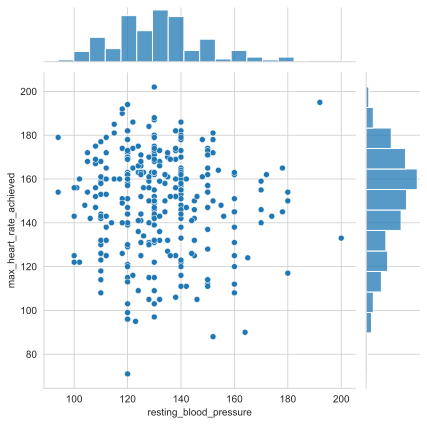

In [141]:
sns.jointplot(x='resting_blood_pressure', y='max_heart_rate_achieved',  data=dt)

CREAING NEW FEATURES

In [142]:
def age_status(row):
   if row['age'] <= 2 :
      return 1 #'Baby'
   if (row['age'] > 2) & (row['age'] <= 7) :
      return 2 #'Little Children'
   if (row['age'] > 7) & (row['age'] <= 15) :
      return 3 #'Children'
   if (row['age'] > 15) & (row['age'] <= 45):
      return 4 #'Adult'
   if (row['age'] > 45) :
      return 5 #'Elder'
    
   return 'Other'
   
dt['Age_Status'] = dt.apply (lambda row: age_status(row), axis=1)
df['Age_Status'] = df.apply (lambda row: age_status(row), axis=1)



In [143]:
df.head()


,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target,Age_Status
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,5
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,4
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,4
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,5
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,5


In [144]:
mean1=df[df['Age_Status'] <= 7]['resting_blood_pressure'].mean()

mean1

131.62376237623764

In [145]:
mean1=df[df['age'] <= 7]['resting_blood_pressure'].mean()
mean2=df[(df['age'] > 7) & (df['age'] <= 18)]['resting_blood_pressure'].mean()
mean3=df[(df['age'] > 18) & (df['age'] <= 30)]['resting_blood_pressure'].mean()
mean4=df[(df['age'] > 30) & (df['age'] <= 45)]['resting_blood_pressure'].mean()
mean5=df[(df['age'] > 45) & (df['age'] <= 55)]['resting_blood_pressure'].mean()
mean6=df[(df['age'] > 55) & (df['age'] <= 65)]['resting_blood_pressure'].mean()
mean7=df[(df['age'] > 65) & (df['age'] <= 70)]['resting_blood_pressure'].mean()
mean8=df[df['age'] > 70]['resting_blood_pressure'].mean()

cholesterol_mean1=df[df['age'] <= 7]['cholesterol'].mean()
cholesterol_mean2=df[(df['age'] > 7) & (df['age'] <= 18)]['cholesterol'].mean()
cholesterol_mean3=df[(df['age'] > 18) & (df['age'] <= 30)]['cholesterol'].mean()
cholesterol_mean4=df[(df['age'] > 30) & (df['age'] <= 45)]['cholesterol'].mean()
cholesterol_mean5=df[(df['age'] > 45) & (df['age'] <= 55)]['cholesterol'].mean()
cholesterol_mean6=df[(df['age'] > 55) & (df['age'] <= 65)]['cholesterol'].mean()
cholesterol_mean7=df[(df['age'] > 65) & (df['age'] <= 70)]['cholesterol'].mean()
cholesterol_mean8=df[df['age'] > 70]['cholesterol'].mean()

max_heart_rate_mean1=df[df['age'] <= 7]['max_heart_rate_achieved'].mean()
max_heart_rate_mean2=df[(df['age'] > 7) & (df['age'] <= 18)]['max_heart_rate_achieved'].mean()
max_heart_rate_mean3=df[(df['age'] > 18) & (df['age'] <= 30)]['max_heart_rate_achieved'].mean()
max_heart_rate_mean4=df[(df['age'] > 30) & (df['age'] <= 45)]['max_heart_rate_achieved'].mean()
max_heart_rate_mean5=df[(df['age'] > 45) & (df['age'] <= 55)]['max_heart_rate_achieved'].mean()
max_heart_rate_mean6=df[(df['age'] > 55) & (df['age'] <= 65)]['max_heart_rate_achieved'].mean()
max_heart_rate_mean7=df[(df['age'] > 65) & (df['age'] <= 70)]['max_heart_rate_achieved'].mean()
max_heart_rate_mean8=df[df['age'] > 70]['max_heart_rate_achieved'].mean()


In [146]:
#Adding Resting Blood Pressure Unit Rate Colum with considering age means

In [147]:
def resting_blood_pressure(row):
   if (row['age'] > 0) & (row['age'] <= 7) :
      return row['resting_blood_pressure'] / mean1
   if (row['age'] > 7) & (row['age'] <= 18) :
      return row['resting_blood_pressure'] / mean2
   if (row['age'] > 18) & (row['age'] <= 30):
      return row['resting_blood_pressure'] / mean3
   if (row['age'] > 30) & (row['age'] <= 45):
      return row['resting_blood_pressure'] / mean4
   if (row['age'] > 45) & (row['age'] <= 55):
      return row['resting_blood_pressure'] / mean5
   if (row['age'] > 55) & (row['age'] <= 65):
      return row['resting_blood_pressure'] / mean6
   if (row['age'] > 65) & (row['age'] <= 70):
      return row['resting_blood_pressure'] / mean7
   if (row['age'] > 70):
      return row['resting_blood_pressure'] / mean8

   return 0
   
df['resting_blood_pressure_unit_rate'] = df.apply (lambda row: resting_blood_pressure(row), axis=1)

In [148]:
df.head(5)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target,Age_Status,resting_blood_pressure_unit_rate
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,5,1.066309
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,4,1.049462
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,4,1.049462
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,5,0.882463
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,5,0.882463


In [149]:
#Cholestrol Unit Rate Colum with considering age means

In [150]:
def cholesterol(row):
   if (row['age'] > 0) & (row['age'] <= 7) :
      return row['cholesterol'] / cholesterol_mean1
   if (row['age'] > 7) & (row['age'] <= 18) :
      return row['cholesterol'] / cholesterol_mean2
   if (row['age'] > 18) & (row['age'] <= 30):
      return row['cholesterol'] / cholesterol_mean3
   if (row['age'] > 30) & (row['age'] <= 45):
      return row['cholesterol'] / cholesterol_mean4
   if (row['age'] > 45) & (row['age'] <= 55):
      return row['cholesterol'] / cholesterol_mean5
   if (row['age'] > 55) & (row['age'] <= 65):
      return row['cholesterol'] / cholesterol_mean6
   if (row['age'] > 65) & (row['age'] <= 70):
      return row['cholesterol'] / cholesterol_mean7
   if (row['age'] > 70):
      return row['cholesterol'] / cholesterol_mean8

   return 0
   
df['cholesterol_unit_rate'] = df.apply (lambda row: cholesterol(row), axis=1)

In [151]:
df.head(5)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target,Age_Status,resting_blood_pressure_unit_rate,cholesterol_unit_rate
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,5,1.066309,0.920270
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,4,1.049462,1.086957
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,4,1.049462,0.886957
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,5,0.882463,0.932119
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,5,0.882463,1.398179


In [152]:
#Max Heart Rate Achieved Unit Rate Colum with considering age means

In [153]:
def max_heart_rate_achieved(row):
   if (row['age'] > 0) & (row['age'] <= 7) :
      return row['max_heart_rate_achieved'] / max_heart_rate_mean1
   if (row['age'] > 7) & (row['age'] <= 18) :
      return row['max_heart_rate_achieved'] / max_heart_rate_mean2
   if (row['age'] > 18) & (row['age'] <= 30):
      return row['max_heart_rate_achieved'] / max_heart_rate_mean3
   if (row['age'] > 30) & (row['age'] <= 45):
      return row['max_heart_rate_achieved'] / max_heart_rate_mean4
   if (row['age'] > 45) & (row['age'] <= 55):
      return row['max_heart_rate_achieved'] / max_heart_rate_mean5
   if (row['age'] > 55) & (row['age'] <= 65):
      return row['max_heart_rate_achieved'] / max_heart_rate_mean6
   if (row['age'] > 65) & (row['age'] <= 70):
      return row['max_heart_rate_achieved'] / max_heart_rate_mean7
   if (row['age'] > 70):
      return row['max_heart_rate_achieved'] / max_heart_rate_mean8

   return 0
   
df['max_heart_rate_achieved_unit_rate'] = df.apply (lambda row: max_heart_rate_achieved(row), axis=1)



In [154]:
df = df.drop(columns = ['cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved'])

In [155]:
df.head()

,age,sex,chest_pain_type,fasting_blood_sugar,rest_ecg,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target,Age_Status,resting_blood_pressure_unit_rate,cholesterol_unit_rate,max_heart_rate_achieved_unit_rate
0,63,1,3,1,0,0,2.3,0,0,1,1,5,1.066309,0.920270,1.038489
1,37,1,2,0,1,0,3.5,0,0,2,1,4,1.049462,1.086957,1.144787
2,41,0,1,0,0,0,1.4,2,0,2,1,4,1.049462,0.886957,1.052959
3,56,1,1,0,1,0,0.8,2,0,2,1,5,0.882463,0.932119,1.232340
4,57,0,0,0,1,1,0.6,2,0,2,1,5,0.882463,1.398179,1.128491


%kendi yas ortalamasinin %10 alti ve ustunun disinda olan olup olmeme olasiligi.
ÖLENLERİN KACI KENDI ARALIKLARINDAKİ  ORTALAMADAN BUYUK FEĞERE SAHIP

In [156]:
dt.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target,Age_Status
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,0,0,normal,1,5
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,0,fixed defect,1,4
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect,1,4
3,56,male,typical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,flat,0,fixed defect,1,5
4,57,female,0,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,flat,0,fixed defect,1,5


In [157]:
dt = dt.drop(columns = ['chest_pain_type', 'thalassemia', 'st_slope'])


In [158]:
dt.head()

,age,sex,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,num_major_vessels,target,Age_Status
0,63,male,145,233,greater than 120mg/ml,normal,150,no,2.3,0,1,5
1,37,male,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,1,4
2,41,female,130,204,lower than 120mg/ml,normal,172,no,1.4,0,1,4
3,56,male,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,0,1,5
4,57,female,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,0,1,5


In [159]:
y = df.target.values
x_data = df.drop(['target'], axis = 1)

In [160]:
x_data

,age,sex,chest_pain_type,fasting_blood_sugar,rest_ecg,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,Age_Status,resting_blood_pressure_unit_rate,cholesterol_unit_rate,max_heart_rate_achieved_unit_rate
0,63,1,3,1,0,0,2.3,0,0,1,5,1.066309,0.920270,1.038489
1,37,1,2,0,1,0,3.5,0,0,2,4,1.049462,1.086957,1.144787
2,41,0,1,0,0,0,1.4,2,0,2,4,1.049462,0.886957,1.052959
3,56,1,1,0,1,0,0.8,2,0,2,5,0.882463,0.932119,1.232340
4,57,0,0,0,1,1,0.6,2,0,2,5,0.882463,1.398179,1.128491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,0,1,1,0.2,1,0,3,5,1.029540,0.951868,0.851561
299,45,1,3,0,1,0,1.2,1,0,3,4,0.888006,1.147826,0.808085
300,68,1,0,1,1,0,3.4,1,2,3,5,1.031573,0.745174,1.038462
301,57,1,0,0,1,1,1.2,1,1,3,5,0.956001,0.517405,0.796175


In [161]:
# Normalize
x= (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values

In [162]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

In [163]:
#transpose matrices
#x_train = x_train.T
#y_train = y_train.T
#x_test = x_test.T
#y_test = y_test.T

In [164]:
from sklearn.feature_selection import RFE

# Build a logistic reggression and compute the feature importances
model = LogisticRegression()

In [165]:
x_train.head()

,age,sex,chest_pain_type,fasting_blood_sugar,rest_ecg,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,Age_Status,resting_blood_pressure_unit_rate,cholesterol_unit_rate,max_heart_rate_achieved_unit_rate
74,0.291667,0.0,0.666667,0.0,0.5,0.0,0.032258,0.5,0.00,0.666667,0.0,0.348637,0.255026,0.636863
153,0.770833,0.0,0.666667,0.0,0.0,0.0,0.000000,0.5,0.25,0.666667,1.0,0.427868,0.342690,0.779833
64,0.604167,1.0,0.666667,1.0,0.0,0.0,0.000000,1.0,0.00,0.666667,1.0,0.406625,0.199840,0.809717
296,0.708333,0.0,0.000000,0.0,0.5,1.0,0.000000,0.5,0.00,0.666667,1.0,0.253851,0.166925,0.547263
287,0.583333,1.0,0.333333,0.0,0.0,0.0,0.000000,1.0,0.25,0.666667,1.0,0.540302,0.249212,0.800667


In [166]:
# create the recursive feature elimination (RFE) model and select 7 attributes
#(RFE) is to select features by recursively considering smaller and smaller sets of features

rfe = RFE(model, 7)
rfe = rfe.fit(x_train, y_train)

In [167]:
# summarize the selection of the attributes
print('Selected features: %s' % list(x_train.columns[rfe.support_]))

Selected features: ['sex', 'chest_pain_type', 'exercise_induced_angina', 'st_depression', 'num_major_vessels', 'thalassemia', 'max_heart_rate_achieved_unit_rate']


Optimal number of features: 10
Selected features: ['age', 'sex', 'chest_pain_type', 'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'Age_Status', 'max_heart_rate_achieved_unit_rate']


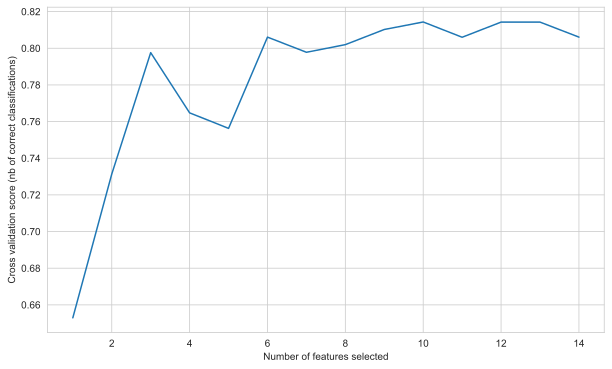

In [168]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=4, scoring='accuracy')
rfecv.fit(x_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [169]:
cols = ['age', 'sex', 'chest_pain_type', 'exercise_induced_angina', 'st_depression', 'st_slope'
        , 'num_major_vessels', 'thalassemia', 'Age_Status', 'max_heart_rate_achieved_unit_rate','target']
df = df[cols]
df.head()


,age,sex,chest_pain_type,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,Age_Status,max_heart_rate_achieved_unit_rate,target
0,63,1,3,0,2.3,0,0,1,5,1.038489,1
1,37,1,2,0,3.5,0,0,2,4,1.144787,1
2,41,0,1,0,1.4,2,0,2,4,1.052959,1
3,56,1,1,0,0.8,2,0,2,5,1.232340,1
4,57,0,0,1,0.6,2,0,2,5,1.128491,1


Creating Model for Logistic Regression

Sklearn Logistic Regression

In [170]:
accuracies = {}

lr = LogisticRegression()
lr.fit(x_train,y_train)
acc = lr.score(x_test,y_test)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.2f}%".format(acc))

Test Accuracy 83.61%


K-Nearest Neighbour (KNN) Classification

In [171]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)

print("{} NN Score: {:.2f}%".format(2, knn.score(x_test, y_test)*100))

2 NN Score: 77.05%


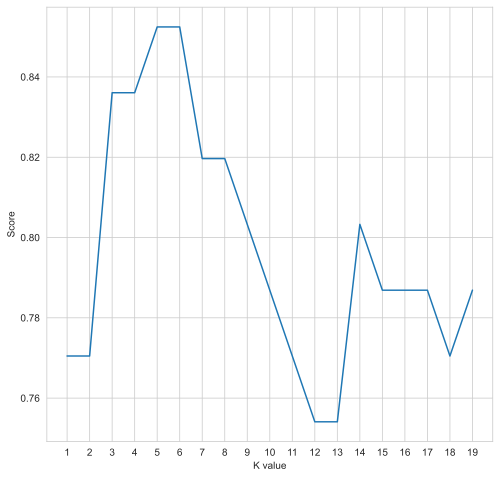

Maximum KNN Score is 85.25%


In [172]:
# try ro find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(x_train, y_train)
    scoreList.append(knn2.score(x_test, y_test))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
accuracies['KNN'] = acc
print("Maximum KNN Score is {:.2f}%".format(acc))

Support Vector Machine (SVM) Algorithm¶

In [173]:
from sklearn.svm import SVC

svm = SVC(random_state = 1)
svm.fit(x_train, y_train)

acc = svm.score(x_test,y_test)*100
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(acc))



Test Accuracy of SVM Algorithm: 81.97%


Naive Bayes Algorithm

In [174]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)

acc = nb.score(x_test,y_test)*100
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.2f}%".format(acc))

Accuracy of Naive Bayes: 81.97%


In [175]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

acc = dtc.score(x_test, y_test)*100
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.2f}%".format(acc))

Decision Tree Test Accuracy 78.69%


Random Forest

In [176]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(x_train, y_train)

acc = rf.score(x_test,y_test)*100
accuracies['Random Forest'] = acc
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(acc))

Random Forest Algorithm Accuracy Score : 83.61%


predictions = xgb.predict(x_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))XGBOOST

In [177]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
xgboost_score= xgb.score(x_test, y_test)
accuracies['XGBOOST'] = xgboost_score*100
print("XGBOOST Algorithm Accuracy Score : {:.2f}%".format(acc))

XGBOOST Algorithm Accuracy Score : 83.61%


# Which is the Best Training/Test Model ?

In [178]:
accuracies

{'Logistic Regression': 83.60655737704919,
 'KNN': 85.24590163934425,
 'SVM': 81.9672131147541,
 'Naive Bayes': 81.9672131147541,
 'Decision Tree': 78.68852459016394,
 'Random Forest': 83.60655737704919,
 'XGBOOST': 81.9672131147541}

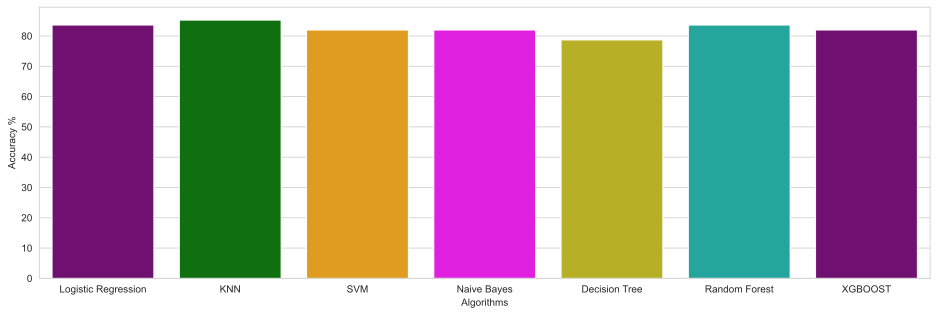

In [179]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

Confusion Matrix

In [180]:
# Predicted values
y_head_lr = lr.predict(x_test)
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(x_train, y_train)
y_head_knn = knn3.predict(x_test)
y_head_svm = svm.predict(x_test)
y_head_nb = nb.predict(x_test)
y_head_dtc = dtc.predict(x_test)
y_head_rf = rf.predict(x_test)
y_head_xgb = xgb.predict(x_test)

In [181]:


from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test,y_head_lr)
cm_knn = confusion_matrix(y_test,y_head_knn)
cm_svm = confusion_matrix(y_test,y_head_svm)
cm_nb = confusion_matrix(y_test,y_head_nb)
cm_dtc = confusion_matrix(y_test,y_head_dtc)
cm_rf = confusion_matrix(y_test,y_head_rf)
cm_xgb =  confusion_matrix(y_test,y_head_xgb)



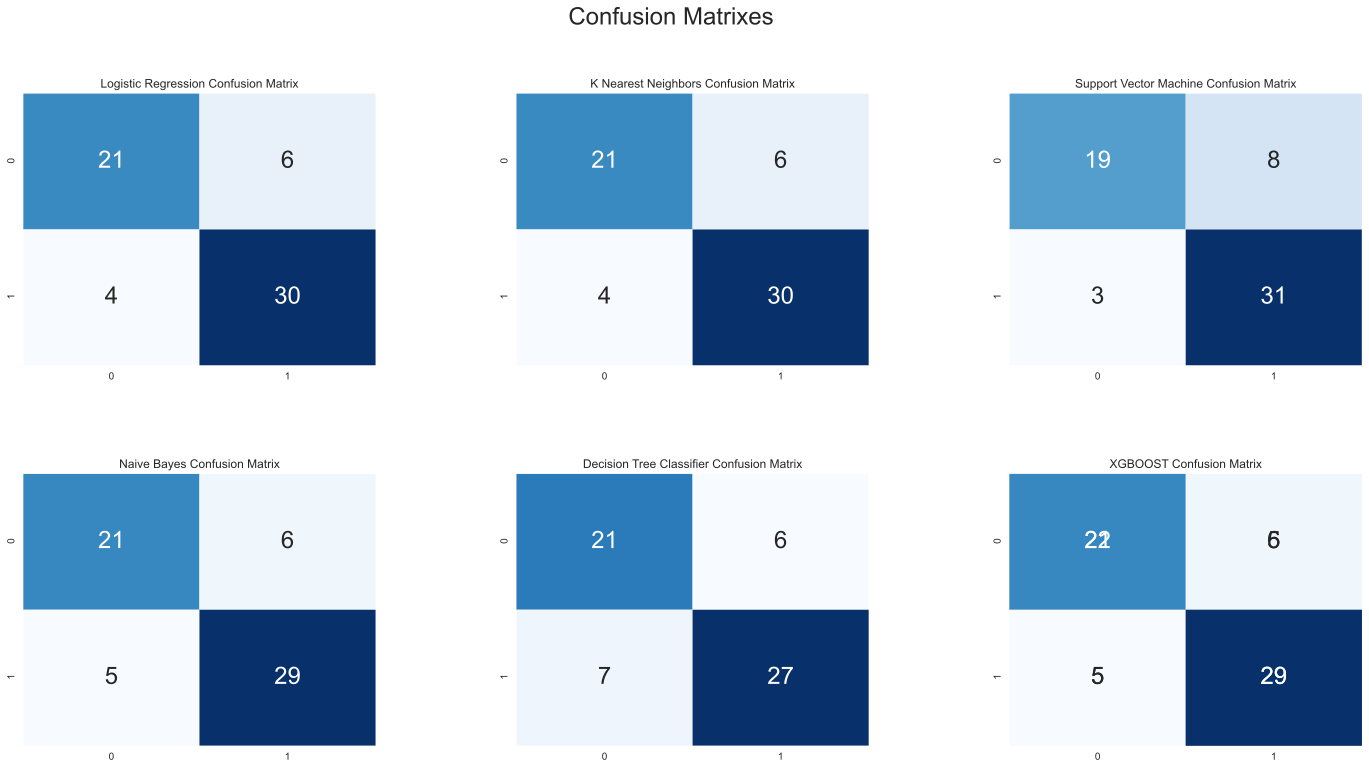

In [182]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("XGBOOST Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

INITIALAZING ANN MODEL

In [183]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from keras import regularizers

In [184]:
X = np.array(df.drop(['target'], 1))
y = np.array(df['target'])

In [185]:
mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

In [186]:
# create X and Y datasets for training
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=42, test_size = 0.2)



In [187]:
# convert the data to categorical labels
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)
print (Y_train.shape)
print (Y_train[:10])



(242, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [188]:
# Check dimensions of both sets.
print("Train Features Size:", X_train.shape)
print("Test Features Size:", X_test.shape)
print("Train Labels Size:", Y_train.shape)
print("Test Labels Size:", Y_test.shape)

Train Features Size: (242, 10)
Test Features Size: (61, 10)
Train Labels Size: (242, 2)
Test Labels Size: (61, 2)


classification_model.add(Dense(1, activation='sigmoid', name = "Output"))

In [189]:
# define a function to build the keras model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=10, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='softmax'))
    
    # compile model
    adam = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model = create_model()

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                176       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 18        
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________
None


In [190]:
# fit the model to the training data
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=100, batch_size=10)

Epoch 1/100
25/25 [==============================] - 1s 20ms/step - loss: 0.6819 - accuracy: 0.5455 - val_loss: 0.6679 - val_accuracy: 0.5410
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6549 - accuracy: 0.5744 - val_loss: 0.6343 - val_accuracy: 0.6885
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6209 - accuracy: 0.6653 - val_loss: 0.5968 - val_accuracy: 0.7213
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 0.5735 - accuracy: 0.7645 - val_loss: 0.5584 - val_accuracy: 0.7705
Epoch 5/100
25/25 [==============================] - 0s 11ms/step - loss: 0.5471 - accuracy: 0.8058 - val_loss: 0.5282 - val_accuracy: 0.7869
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.5128 - accuracy: 0.8223 - val_loss: 0.5018 - val_accuracy: 0.8033
Epoch 7/100
25/25 [==============================] - 0s 18ms/step - loss: 0.5105 - accuracy: 0.8430 - val_loss: 0.4824 - val_accuracy: 0.8033
Epoch 8/10

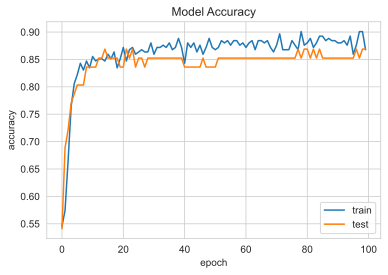

In [191]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

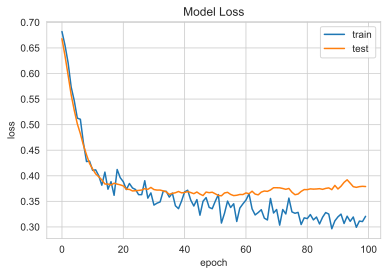

In [192]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [193]:
# convert into binary classification problem - heart disease or no heart disease
Y_train_binary = Y_train.copy()
Y_test_binary = Y_test.copy()

Y_train_binary[Y_train_binary > 0] = 1
Y_test_binary[Y_test_binary > 0] = 1

print(Y_train_binary[:20])

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [194]:
# Check dimensions of both sets.
print("Train Features Size:", X_train.shape)
print("Test Features Size:", X_test.shape)
print("Train Labels Size:", Y_train_binary.shape)
print("Test Labels Size:", Y_test_binary.shape)

Train Features Size: (242, 10)
Test Features Size: (61, 10)
Train Labels Size: (242, 2)
Test Labels Size: (61, 2)


In [195]:
# define a new keras model for binary classification
def create_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=10, kernel_initializer='normal',  kernel_regularizer=regularizers.l2(0.001),activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, kernel_initializer='normal',  kernel_regularizer=regularizers.l2(0.001),activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='sigmoid'))
    
    # Compile model
    adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

binary_model = create_binary_model()

print(binary_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                176       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 18        
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________
None


In [196]:
# fit the binary model on the training data
history=binary_model.fit(X_train, Y_train_binary, validation_data=(X_test, Y_test_binary), epochs=100, batch_size=10)




Epoch 1/100
25/25 [==============================] - 0s 13ms/step - loss: 0.6900 - accuracy: 0.5413 - val_loss: 0.6853 - val_accuracy: 0.5410
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6793 - accuracy: 0.5455 - val_loss: 0.6752 - val_accuracy: 0.5410
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.5455 - val_loss: 0.6562 - val_accuracy: 0.5410
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.5455 - val_loss: 0.6345 - val_accuracy: 0.5410
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6140 - accuracy: 0.5455 - val_loss: 0.6129 - val_accuracy: 0.5410
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5890 - accuracy: 0.6116 - val_loss: 0.5919 - val_accuracy: 0.7049
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5807 - accuracy: 0.7521 - val_loss: 0.5745 - val_accuracy: 0.7705
Epoch 8/100


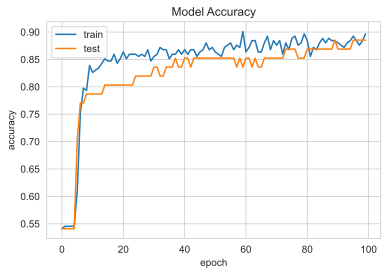

In [197]:


import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()



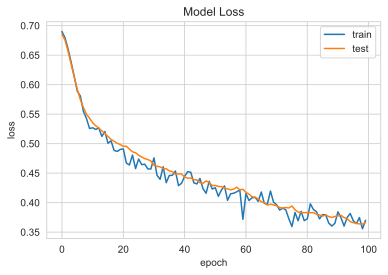

In [198]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()